<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Time Series Theory in Python - Part 3: Time Series Preprocessing

This notebook presents several techniques for time series preprocessing for preparing data for analysis and predictive modeling. These techniques can also serve as independent data analyses on their own and facilitate further preprocessing tailored to specific tasks.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.cluster import DBSCAN
from scipy.interpolate import interp1d

from PythonTsa.datadir import getdtapath
dtapath=getdtapath()

## 1. Data Transformation
Data transformation encompasses techniques used to modify the data, enhancing its structure and utility for analysis and prediction. This includes fundamental time series operations such as aggregation, where data is summarized or resampled over specified intervals (see Notebook B1), as well as differencing (see Notebook C2). More techniques such as smoothing, detrending, and scaling are introduced below.

## 1.1 Smoothing

Smoothing techniques like moving averages reduce noise and highlight trends, making the data easier to analyze and model.

### **Example 1: Australian Employed Total Persons**

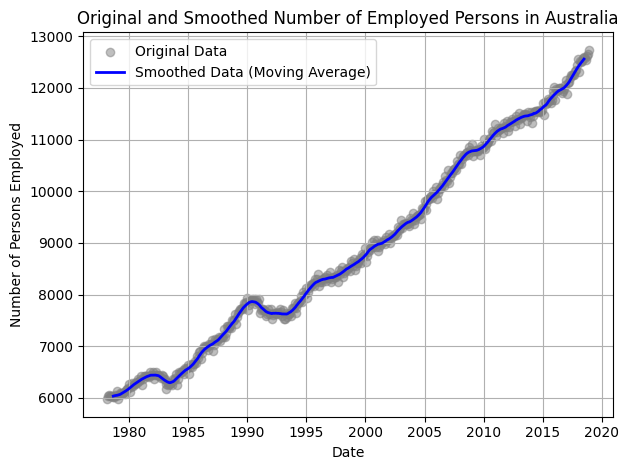

In [3]:
# Load the Excel file containing employment data
aul = pd.read_excel(dtapath + 'AustraliaEmployedTotalPersons.xlsx', header=0)

# Create a time index starting from February 1978 with monthly frequency
timeindex = pd.date_range('1978-02', periods=len(aul), freq='ME')
aul.index = timeindex

# Extract the 'EmployedP' column for analysis
aults = aul['EmployedP']

# Apply smoothing using a moving average
window_size = 12  # Define the window size for moving average (e.g., 12 for yearly smoothing)
aults_smoothed = pd.Series(aults).rolling(window=window_size, center=True).mean().values

# Plotting the results
plt.figure()
plt.scatter(aults.index, aults, label='Original Data', color='gray', alpha=0.5)  # Original data
plt.plot(aults.index, aults_smoothed, label='Smoothed Data (Moving Average)', color='blue', linewidth=2)  # Smoothed data

# Adding titles and labels
plt.title('Original and Smoothed Number of Employed Persons in Australia')
plt.xlabel('Date')
plt.ylabel('Number of Persons Employed')  # Clarified y-axis label
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1.2 Removing Trends

In notebook C1, time series decomposition is used to explore the various components of the time series, including trend, seasonality, and residuals. This process not only helps in understanding the underlying structure of the data but can also serve as a preprocessing step for further analysis or predictions. For example, decomposition (introduced in notebook C1 as part of exploratory analysis) or detrending may be employed to make the data stationary or to specifically examine the effects of seasonality and noise. The following example demonstrates detrending which is achieved by fitting a regression model (detailed more in notebook C4).

### **Example 2: Mean Spring Passage Dates of European Pied Flycatcher**

The dataset contains the migration data of the European Pied Flycatcher, focusing on the adjusted mean spring passage dates (MADJDAYSWS) across multiple years. The dataset includes annual observations.

**Original dataset and code:** Haest, B., Hüppop, O., & Bairlein, F. (2020). Code and data for: "Weather at the winter and stopover areas determines spring migration onset, progress, and advancements in Afro-Palearctic migrant birds". In Proceedings of the National Academy of Sciences of the United States of America (v1.0, Bd. 117, Nummer 29, S. 17056–17062). Zenodo. doi:10.5281/zenodo.3629178                  

**Related publication(s):** Haest, B., Hüppop, O., and Bairlein, F.: Weather at the winter and stopover areas determines spring migration onset, progress, and advancements in Afro-Palearctic migrant birds, Proceedings of the National Academy of Sciences, 117, 17056–17062, doi:10.1073/pnas.1920448117,                  2020.

Original data and code were modified for this notebook.

In [4]:
bird_migration = pd.read_csv('../Datasets/bird_migration.csv', sep = ';')

Length of y: 55
Length of time: 55


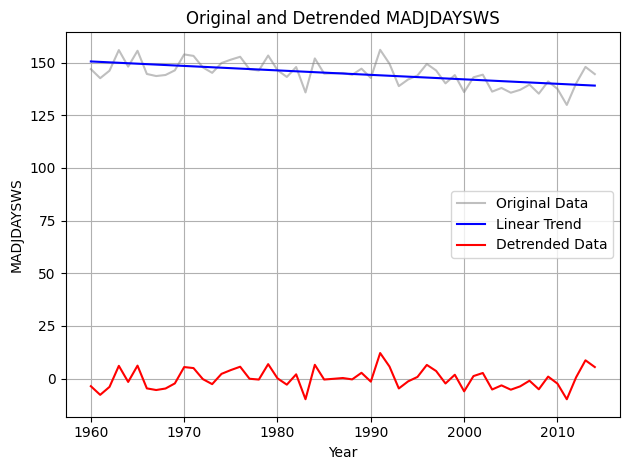

In [5]:
# Assuming the 'MADJDAYSWS' is the column you want as y
y = bird_migration['MADJDAYSWS'].values  # Extracting dependent variable
time = bird_migration['Year'].values  # Using the Year column as the time variable

# Checking the lengths
print(f'Length of y: {len(y)}')
print(f'Length of time: {len(time)}')

linear_model = sm.OLS(y, sm.add_constant(time)).fit()

# Perform linear detrending
trend = linear_model.fittedvalues  # This is the linear trend
detrended_y = y - trend

# Plot
plt.figure()
plt.plot(time, y, label='Original Data', color='gray', alpha=0.5)  # Original data
plt.plot(time, trend, label='Linear Trend', color='blue', linewidth=1.5)  # Linear trend
plt.plot(time, detrended_y, label='Detrended Data', color='red', linewidth=1.5)
plt.title('Original and Detrended MADJDAYSWS')
plt.xlabel('Year')
plt.ylabel('MADJDAYSWS')  # Optionally change to 'Detrended MADJDAYSWS'
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## 1.3 Scaling

Normalization (min-max scaling) and standardization (Z-score normalization) are used for bringing features onto a similar scale.

Note: Most preprocessing functions expect input data to have the shape of (n_samples, n_features). This ensures that the data is correctly interpreted as multiple samples of one or more features.

In [6]:
# reshape data for scaling
values = y.reshape((len(y), 1))

## 1.3.1 Normalization

$$y = (x - min) / (max - min)$$

In [7]:
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)

# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
print(normalized[:5])

# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
print(inversed[:5])

[[0.65022842]
 [0.48543924]
 [0.62153771]
 [0.99508034]
 [0.69505867]]
[[146.9354839]
 [142.620438 ]
 [146.1842105]
 [155.9655172]
 [148.109375 ]]


In [8]:
# check normalization
print("Min value normalized:", min(normalized))
print("Max value normalized:", max(normalized))

Min value normalized: [0.]
Max value normalized: [1.]


## 1.3.2 Standardization

$$y = (x - mean) / std$$

In [9]:
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)

# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
print(normalized[:5])
    
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
print(inversed[:5])

[[ 0.36591566]
 [-0.3843376 ]
 [ 0.23529241]
 [ 1.93595967]
 [ 0.57001908]]
[[146.9354839]
 [142.620438 ]
 [146.1842105]
 [155.9655172]
 [148.109375 ]]


In [10]:
# check standardization
print("Min value normalized:", min(normalized))
print("Max value normalized:", max(normalized))

Min value normalized: [-2.59444842]
Max value normalized: [1.95835791]


## 2. Outlier/Anomaly Detection

### **Example 3: Artificial Streamflow Time Series with Outliers and Change Point**

We create an artificial time series to simulate the dynamics of streamflow over a defined period while incorporating features like outliers and a change point. 

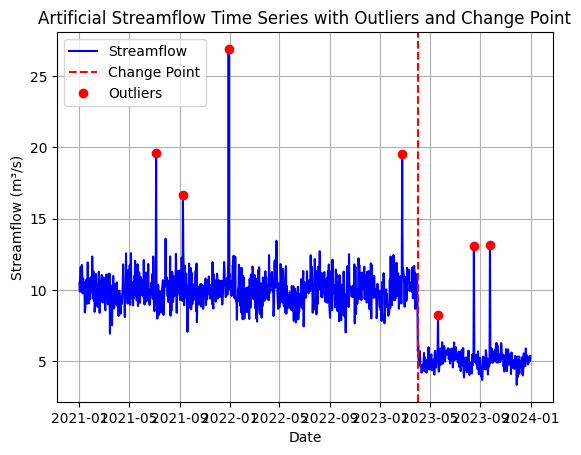

In [11]:
# Parameters
np.random.seed(42)  # For reproducibility
days = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
n = len(days)

# Generate a normal streamflow pattern (in m³/s)
streamflow = 10 + 0.5 * np.sin(np.linspace(0, 20 * np.pi, n)) + np.random.normal(0, 1, n)

# Introduce a change point after 1.5 years (midway through the second year)
change_point_index = int(n * 0.75)
streamflow[change_point_index:] *= 0.5  # Effect of drying out

# Introduce a total of 7 random outliers
outliers_indices = np.random.choice(range(n), size=7, replace=False)
streamflow[outliers_indices] += np.random.normal(10, 5, size=7)  # Adding outliers above mean

# Create a DataFrame
sf = pd.DataFrame(data={'Date': days, 'Streamflow (m³/s)': streamflow})

# Plot the time series
plt.figure()
plt.plot(sf['Date'], sf['Streamflow (m³/s)'], label='Streamflow', color='b')
plt.axvline(x=sf['Date'][change_point_index], color='r', linestyle='--', label='Change Point')
plt.plot(sf['Date'][outliers_indices], sf['Streamflow (m³/s)'][outliers_indices], 'ro', label='Outliers')  # Mark all outliers in red
plt.title('Artificial Streamflow Time Series with Outliers and Change Point')
plt.xlabel('Date')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.grid()
plt.show()

## 2.1 Z-Score

The Z-score quantifies how many standard deviations a data point is from the mean of a dataset. Outlier are detected by identifying points with Z-scores that exceed a specified threshold (typically ±3), indicating significant deviations from the average.

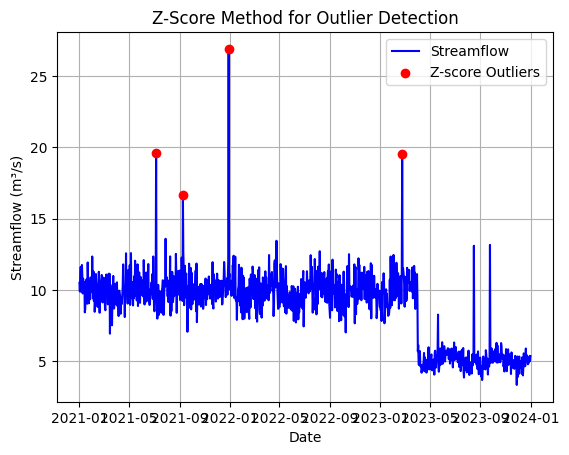

In [12]:
mean = np.mean(streamflow)
std_dev = np.std(streamflow)
z_scores = (streamflow - mean) / std_dev
outliers_z = np.where(np.abs(z_scores) > 3)[0]

plt.figure()
plt.plot(sf['Date'], sf['Streamflow (m³/s)'], label='Streamflow', color='b')
plt.scatter(sf['Date'][outliers_z], streamflow[outliers_z], color='red', label='Z-score Outliers', zorder=5)
plt.title('Z-Score Method for Outlier Detection')
plt.xlabel('Date')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.grid()

## 2.2 Moving Average Method

The moving average method is primarily used for smoothing time series data (see 1.1), which can also serve as an effective outlier/anomaly detection method by highlighting deviations from the expected average within a specified time window.

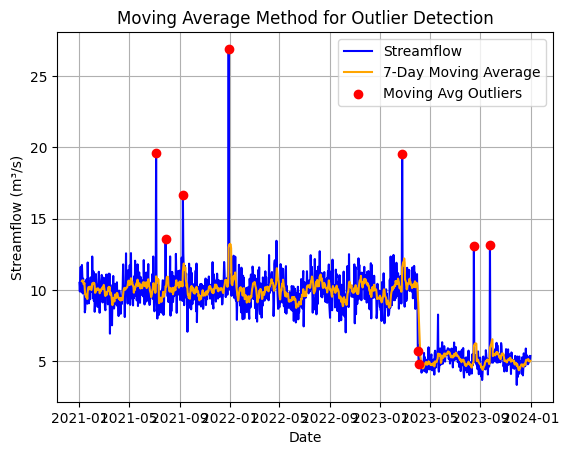

In [13]:
moving_average = pd.Series(streamflow).rolling(window=7).mean()
differences = np.abs(streamflow - moving_average)
outlier_threshold = differences.mean() + 3 * differences.std()  # Define threshold for outliers
outliers_moving_avg = np.where(differences > outlier_threshold)[0]

plt.figure()
plt.plot(sf['Date'], streamflow, label='Streamflow', color='b')
plt.plot(sf['Date'], moving_average, label='7-Day Moving Average', color='orange')
plt.scatter(sf['Date'][outliers_moving_avg], streamflow[outliers_moving_avg], color='red', label='Moving Avg Outliers', zorder=5)
plt.title('Moving Average Method for Outlier Detection')
plt.xlabel('Date')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.grid()

## 2.3 Density-based Methods: DBSCAN

Density-based outlier methods such as DBSCAN are techniques that identify outliers by analyzing the density of data points in their local neighborhood, flagging those points that reside in low-density regions compared to their high-density surroundings as potential outliers.

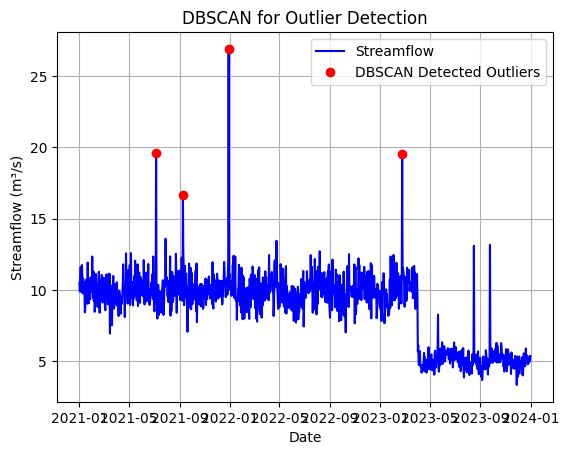

In [14]:
# DBSCAN Outlier Detection
scaler = StandardScaler()
sf_scaled = scaler.fit_transform(sf[['Streamflow (m³/s)']])  # Scale the data

# Fit DBSCAN (adjust eps and min_samples as needed)
dbscan = DBSCAN(eps=0.5, min_samples=10)  # eps controls the neighborhood radius, and min_samples controls density threshold
sf['Outlier'] = dbscan.fit_predict(sf_scaled)

# DBSCAN labels outliers as -1, so we mark them
dbscan_outliers = sf[sf['Outlier'] == -1]

# Plot the time series with outliers
plt.figure()
plt.plot(sf['Date'], sf['Streamflow (m³/s)'], label='Streamflow', color='b')
plt.plot(dbscan_outliers['Date'], dbscan_outliers['Streamflow (m³/s)'], 'ro', label='DBSCAN Detected Outliers')
plt.title('DBSCAN for Outlier Detection')
plt.xlabel('Date')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.grid()
plt.show()

## 3. Data Availability and Handling Missing Values

## 3.1 Data Availability in Time Series

### **Example 4: Large Dataset of Synthetic Time Series with Gaps**

We generate multiple synthetic independent time series with trend, seasonal effect, random noise AND gaps.

/tmp/ipykernel_115/3684030169.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range('2000-01-01', periods=100, freq='M')


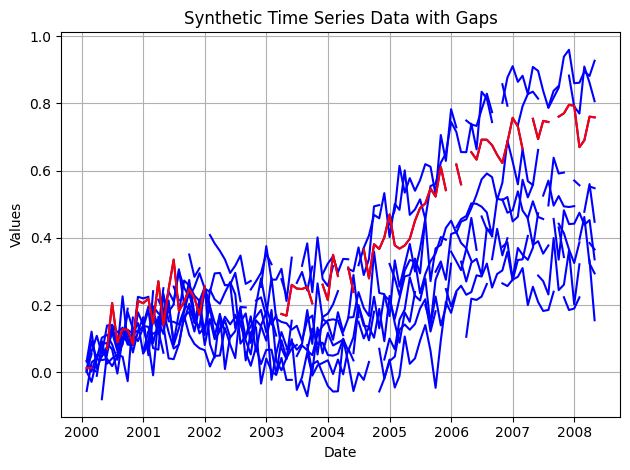

In [40]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic time series data
dates = pd.date_range('2000-01-01', periods=100, freq='M')

# Create a DataFrame to hold the time series
data = pd.DataFrame(index=dates)

# Generate time series
n_series = 10
for i in range(1, n_series + 1):  # 24 time series
    trend = np.linspace(0, np.random.uniform(0.1, 1), len(dates))  # Linear trend
    seasonal = 0.1 * np.sin(np.linspace(0, 3 * np.pi, len(dates)))  # Seasonal effect
    noise = np.random.normal(loc=0, scale=0.05, size=len(dates))  # Random noise
    series = trend + seasonal + noise  # Combine to create the time series
    data[f'Series_{i}'] = series

# Add gaps (missing values) to the series
num_gaps = 10  # Number of NaN values to insert in each series
for column in data.columns:
    indices = np.random.choice(data.index, num_gaps, replace=False)  # Select random indices
    data.loc[indices, column] = np.nan  # Assign NaN values
data.loc[data.index.year == int(2002), 'Series_2'] = np.nan # one series data gap spans over a total year

# Plotting all the time series; highlight the last two series
plt.figure()
for column in data.columns:
    plt.plot(data.index, data[column], label=column, color='blue')
plt.plot(data.index, data['Series_2'], label=column, color='red')
plt.title('Synthetic Time Series Data with Gaps')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid()
plt.tight_layout()
plt.show()

One way to easily analyse data availability in a large number of time series is the heatmap:

          2000-01-31  2000-02-29  2000-03-31  2000-04-30  2000-05-31  \
Series_1           1           1           1           1           1   
Series_2           1           1           0           0           1   
Series_3           1           1           1           1           1   
Series_4           1           1           1           1           1   
Series_5           1           1           1           1           1   

          2000-06-30  2000-07-31  2000-08-31  2000-09-30  2000-10-31  ...  \
Series_1           1           1           1           1           1  ...   
Series_2           1           1           1           1           1  ...   
Series_3           1           1           1           1           1  ...   
Series_4           1           1           1           1           1  ...   
Series_5           1           1           1           1           0  ...   

          2007-07-31  2007-08-31  2007-09-30  2007-10-31  2007-11-30  \
Series_1           0           1

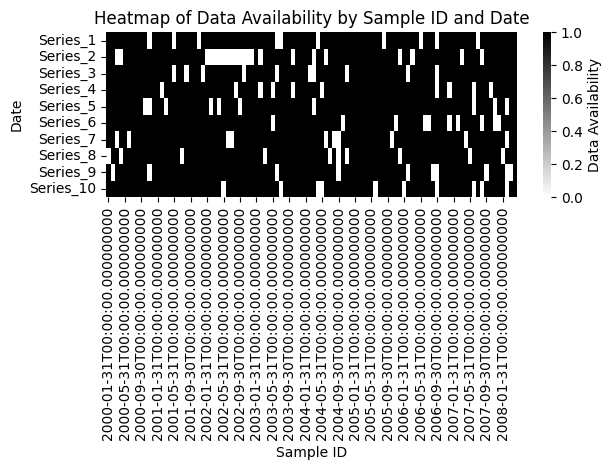

In [41]:
# prepare data for heatmap
heatmap_data = data.notna().astype(int)  # Convert to binary (1 for available, 0 for NaN)
heatmap_data = heatmap_data.T
print(heatmap_data.head())

# plot heatmap
import seaborn as sns
plt.figure()  
sns.heatmap(heatmap_data, cmap='binary', cbar_kws={'label': 'Data Availability'}, annot=False)
plt.title("Heatmap of Data Availability by Sample ID and Date")
plt.xlabel("Sample ID")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

## 3.2 Handling Missing Values: Linear Interpolation

Common methods for handling gaps in time series data include forward fill (propagating the last observed value), backward fill (using the next observed value), interpolation (estimating missing values based on surrounding data), and imputation techniques such as mean/median filling. More sophisticated approaches entail using predictive modeling techniques to estimate missing values based on existing patterns in the data. Linear interpolation is one of the simplest and most widely used methods. 

### **Example 3 [continued]: Artificial Streamflow Time Series with Outliers and Change Point**

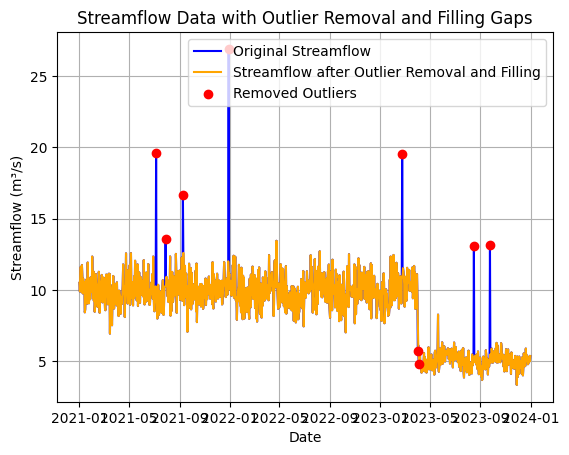

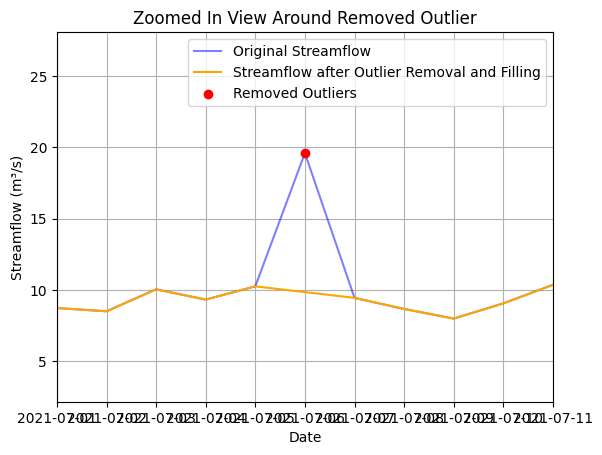

In [42]:
# Remove outliers from the data
filtered_streamflow = sf['Streamflow (m³/s)'].copy()
filtered_streamflow[outliers_moving_avg] = np.nan  # Set outlier points to NaN

# Fill the gaps using linear interpolation
filled_streamflow = filtered_streamflow.interpolate(method='linear')

# Plotting the original data and the filled data
plt.figure()
plt.plot(sf['Date'], sf['Streamflow (m³/s)'], label='Original Streamflow', color='b')
plt.plot(sf['Date'], filled_streamflow, label='Streamflow after Outlier Removal and Filling', color='orange')
plt.scatter(sf['Date'][outliers_moving_avg], streamflow[outliers_moving_avg], color='red', label='Removed Outliers', zorder=5)
plt.title('Streamflow Data with Outlier Removal and Filling Gaps')
plt.xlabel('Date')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.grid()
plt.show()

# Zooming in on one of the removed outlier points (e.g., using the first outlier)
outlier_to_zoom = outliers_moving_avg[0]  # Choose an example outlier to zoom in
start_date = sf['Date'][outlier_to_zoom - 5]  # 5 days before
end_date = sf['Date'][outlier_to_zoom + 5]    # 5 days after

# zoomed-in
plt.figure()
plt.plot(sf['Date'], sf['Streamflow (m³/s)'], label='Original Streamflow', color='b', alpha=0.5)
plt.plot(sf['Date'], filled_streamflow, label='Streamflow after Outlier Removal and Filling', color='orange')
plt.scatter(sf['Date'][outliers_moving_avg], streamflow[outliers_moving_avg], color='red', label='Removed Outliers', zorder=5)
plt.xlim([start_date, end_date])
plt.title('Zoomed In View Around Removed Outlier')
plt.xlabel('Date')
plt.ylabel('Streamflow (m³/s)')
plt.legend()
plt.grid()
plt.show()

### **Example 4 [continued]: Large Dataset of Synthetic Time Series with Gaps**

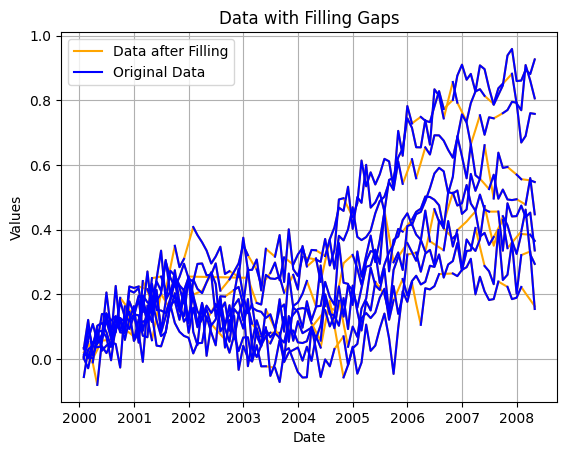

In [43]:
# Fill the gaps using linear interpolation
data_filled = data.interpolate(method='linear')

# Plotting the original data and the filled data
plt.figure()
plt.plot(data_filled, label='Data after Filling', color='orange')
plt.plot(data, label='Original Data', color='b')
plt.title('Data with Filling Gaps')
plt.xlabel('Date')
plt.ylabel('Values')
handles, labels = plt.gca().get_legend_handles_labels() # Create handles for the legend manually
by_label = dict(zip(labels, handles)) # Remove duplicates by turning the labels into a set and getting unique corresponding handles
plt.legend(by_label.values(), by_label.keys()) # Create the legend with unique entries
plt.grid()
plt.show()

### Aggregation with Missing Data

When data is missing, aggregation methods alone (see notebook B1) cannot adequately provide values for periods without available data:

In [47]:
data['Series_2'].resample('YE').mean()

2000-12-31    0.114785
2001-12-31    0.220516
2002-12-31         NaN
2003-12-31    0.228554
2004-12-31    0.345150
2005-12-31    0.471384
2006-12-31    0.657803
2007-12-31    0.745535
2008-12-31    0.719683
Freq: YE-DEC, Name: Series_2, dtype: float64

In such cases, interpolation at fixed time points can effectively estimate these missing values:

            Series_1  Series_2  Series_3  Series_4  Series_5  Series_6  \
2000-12-31  0.058974  0.205612  0.141624  0.219943  0.132629  0.163793   
2001-12-31  0.230375  0.255113  0.359083  0.249308  0.253302  0.081225   
2002-12-31  0.195282  0.251565  0.375380  0.353160  0.167446  0.179219   
2003-12-31  0.154712  0.214957  0.256774  0.323502  0.174714  0.051513   
2004-12-31  0.213498  0.469694  0.439563  0.402694  0.167248  0.100290   
2005-12-31  0.411413  0.580124  0.782761  0.744789  0.450985  0.358743   
2006-12-31  0.482058  0.757005  0.910598  0.764148  0.627048  0.412154   
2007-12-31  0.442135  0.792969  0.859985  0.790652  0.570558  0.377206   
2008-12-31       NaN       NaN       NaN       NaN       NaN       NaN   

            Series_7  Series_8  Series_9  Series_10  
2000-12-31  0.137979  0.055818  0.070078   0.133399  
2001-12-31  0.135990  0.110751  0.065810   0.253070  
2002-12-31  0.066758  0.118909  0.040922   0.094134  
2003-12-31  0.035798  0.145880 -0.040609   

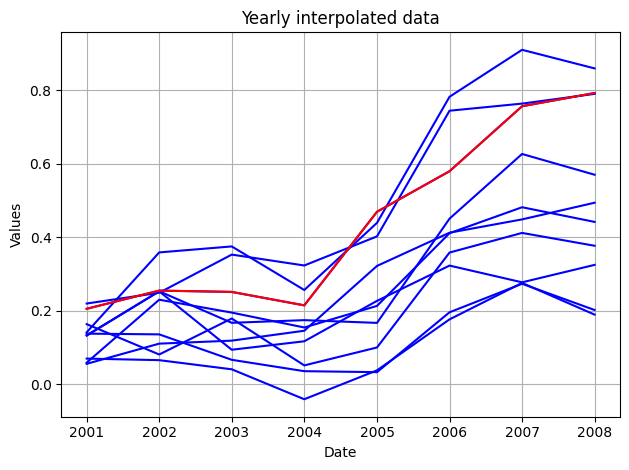

In [48]:
# Define the sequence for interpolation (years from 2000 to 2009)
seq_interpol = pd.date_range(start='2000-01-01', end='2009-01-01', freq='YE')

# Date data type must be similar to seq_interpol
data.index = data.index.astype(np.int64)

# Create a new DataFrame to store interpolated values by year
interpolated_data = pd.DataFrame()

# Loop through each column to perform interpolation
for col in data.columns:
    
    # 1. Drop NaN values for interpolation
    df = data[[col]].dropna()
    
    # 2. Interpolate using linear interpolation
    f = interp1d(df.index, df[col], 
                 kind='linear',  
                 bounds_error=False, 
                 fill_value=np.nan) # no extrapolation

    # 3. Get interpolated values for the specific years in seq_interpol
    interpolated_values = f(seq_interpol)

    # Store result to the DataFrame
    interpolated_data[col] = interpolated_values

# Set the index of the new DataFrame to the sequence of years
interpolated_data.index = seq_interpol

# Print results
print(interpolated_data)

# Plot results
plt.figure()
plt.plot(interpolated_data, label='Original Data', color='b')
plt.plot(interpolated_data.index, interpolated_data['Series_2'], label=column, color='red')
plt.title('Yearly interpolated data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid()
plt.tight_layout()
plt.show()